(41, 53, 33)


/tmp/ipykernel_36/417770616.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gray')


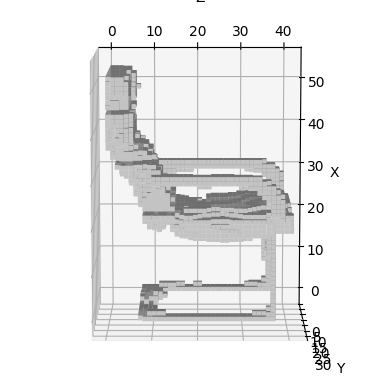

In [1]:

#author: harun ijaz

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


if __name__ == "__main__":
    
    import scipy.io
    mat = scipy.io.loadmat('/kaggle/input/datafile/discretized_voxel.mat')
    # Now that we know the data is under 'voxels3D', let's extract and visualize it
    voxel_data = mat['voxels3D']
    voxel_data = np.where(voxel_data != 0, 1, voxel_data)
    print(voxel_data.shape)
    
    
    voxels=voxel_data
    
    aspect_ratio = np.array(voxels.shape) / np.min(voxels.shape)

    # create a colormap that maps voxel values to colors and opacities
    cmap = plt.cm.get_cmap('gray')

    norm =matplotlib.colors.Normalize(vmin=0, vmax=1)

    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
   
    # create an array of colors and opacities for each voxel
    colors = np.zeros(voxels.shape + (4,))
    colors[..., 3] = voxels  # set the alpha channel to the voxel values
    colors[..., :3] = cmap(norm(voxels))[:, :, :, :3]  # set the color channels

    # # Plot the voxels    
    ax.voxels(voxels, facecolors=colors)

    # Set the axis labels and title
    ax.set_xlabel('Z')
    ax.set_ylabel('X')
    ax.set_zlabel('Y')
    # lock the aspect ratio of the plot
    ax.set_box_aspect(aspect_ratio)
    # view seat and back part for load/force
    ax.view_init(elev=99, azim=-90) 

    # show the plot
    plt.show()

Epoch 0, Loss: 12347.9922, Force direction: [-0.5437687039375305, 0.42508718371391296, 0.723613440990448]
Epoch 10, Loss: 2236.9019, Force direction: [-0.5673342943191528, -0.7807303071022034, 0.26190096139907837]
Epoch 20, Loss: 136.3211, Force direction: [-0.007963359355926514, 0.5753991603851318, 0.8178339600563049]
Epoch 30, Loss: 135.2215, Force direction: [-0.8865528106689453, -0.09965179860591888, 0.451767235994339]
Epoch 40, Loss: 72.8910, Force direction: [-0.6768918037414551, -0.05754698067903519, 0.7338295578956604]
Epoch 50, Loss: 55.8118, Force direction: [0.030907707288861275, 0.9810691475868225, -0.19117532670497894]
Epoch 60, Loss: 19.1345, Force direction: [-0.3539518713951111, 0.8017905354499817, 0.4815080463886261]
Epoch 70, Loss: 4.6053, Force direction: [0.36464735865592957, 0.8143510222434998, -0.45151379704475403]
Epoch 80, Loss: 2.5514, Force direction: [-0.7762019634246826, -0.23198087513446808, -0.5862553715705872]
Epoch 90, Loss: 3.7739, Force direction: [-0.

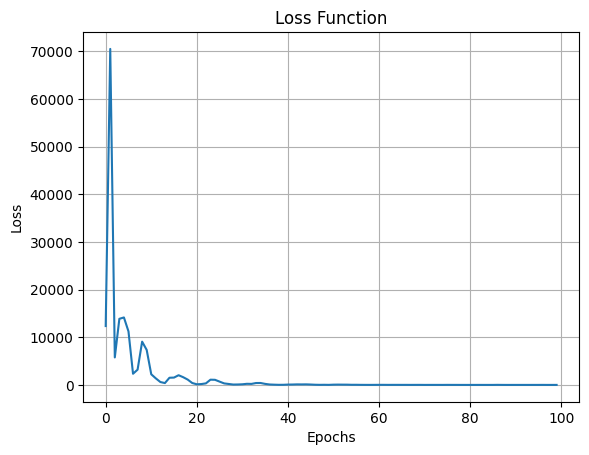

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

# Neural network model (3D input, 3D output)
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
        )
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

# PINN model for 3D voxel input (Chair)
class VoxelChairPINN:
    def __init__(self, voxel_file, E, nu, force_magnitude):
        self.E = E  # Young's modulus
        self.nu = nu  # Poisson's ratio
        self.force_magnitude = force_magnitude 
        
        # Calculate Lamé constants
        self.lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))  # First Lamé constant
        self.mu = E / (2 * (1 + nu))  # Second Lamé constant (shear modulus)

        # Load voxel data from .mat file
        mat_data = loadmat(voxel_file)
        self.voxel_3d = torch.tensor(mat_data['voxels3D'], dtype=torch.float32)
        self.num_points = self.voxel_3d.shape

        # Create coordinate tensors
        self.x = torch.linspace(0, 1, self.num_points[0], requires_grad=True)
        self.y = torch.linspace(0, 1, self.num_points[1], requires_grad=True)
        self.z = torch.linspace(0, 1, self.num_points[2], requires_grad=True)
        self.X, self.Y, self.Z = torch.meshgrid(self.x, self.y, self.z)
        self.xyz = torch.stack([self.X.flatten(), self.Y.flatten(), self.Z.flatten()], dim=1)

        # Input: x, y, z, force_direction (3), voxel_value
        self.model = FFNN(input_dim=7, hidden_dim=80, output_dim=3)  # 3D input, 3 displacement outputs
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_history = []  # Store loss for visualization

    def strain_tensor(self, u, v, w, x, y, z):
        # Compute the strain tensor in 3D
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_z = torch.autograd.grad(u, z, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_z = torch.autograd.grad(v, z, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        w_x = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(w), create_graph=True)[0]
        w_y = torch.autograd.grad(w, y, grad_outputs=torch.ones_like(w), create_graph=True)[0]
        w_z = torch.autograd.grad(w, z, grad_outputs=torch.ones_like(w), create_graph=True)[0]
        
        epsilon_xx = u_x
        epsilon_yy = v_y
        epsilon_zz = w_z
        epsilon_xy = 0.5 * (u_y + v_x)
        epsilon_xz = 0.5 * (u_z + w_x)
        epsilon_yz = 0.5 * (v_z + w_y)
        
        return epsilon_xx, epsilon_yy, epsilon_zz, epsilon_xy, epsilon_xz, epsilon_yz

    def stress_tensor(self, epsilon_xx, epsilon_yy, epsilon_zz, epsilon_xy, epsilon_xz, epsilon_yz):
        # Compute the stress tensor using the constitutive equation
        trace_epsilon = epsilon_xx + epsilon_yy + epsilon_zz
        sigma_xx = self.lambda_ * trace_epsilon + 2 * self.mu * epsilon_xx
        sigma_yy = self.lambda_ * trace_epsilon + 2 * self.mu * epsilon_yy
        sigma_zz = self.lambda_ * trace_epsilon + 2 * self.mu * epsilon_zz
        sigma_xy = 2 * self.mu * epsilon_xy
        sigma_xz = 2 * self.mu * epsilon_xz
        sigma_yz = 2 * self.mu * epsilon_yz
        
        return sigma_xx, sigma_yy, sigma_zz, sigma_xy, sigma_xz, sigma_yz

    def strain_energy_density(self, u, v, w, x, y, z):
        # Compute strain tensor
        epsilon_xx, epsilon_yy, epsilon_zz, epsilon_xy, epsilon_xz, epsilon_yz = self.strain_tensor(u, v, w, x, y, z)
        
        # Compute stress tensor
        sigma_xx, sigma_yy, sigma_zz, sigma_xy, sigma_xz, sigma_yz = self.stress_tensor(epsilon_xx, epsilon_yy, epsilon_zz, epsilon_xy, epsilon_xz, epsilon_yz)
        
        # Compute strain energy density
        energy_density = 0.5 * (sigma_xx * epsilon_xx + sigma_yy * epsilon_yy + sigma_zz * epsilon_zz + 
                                2 * sigma_xy * epsilon_xy + 2 * sigma_xz * epsilon_xz + 2 * sigma_yz * epsilon_yz)
        
        return energy_density

    def internal_energy(self, u, v, w):
        # Compute the strain energy density
        energy_density = self.strain_energy_density(u, v, w, self.X, self.Y, self.Z)
        
        # Integrate over the domain
        E_in = torch.sum(energy_density * self.voxel_3d**3)
        
        return E_in

    def external_work(self, u, v, w, force_direction):
        # Compute traction vector T
        force_x, force_y, force_z = force_direction
        T = self.force_magnitude * torch.tensor([force_x, force_y, force_z])
        
        # Compute displacement vector u at the surface
        # Assume force is applied at the center of the top surface
        u_surface = torch.stack([
            u[self.num_points[0]//2, self.num_points[1]//2, -1],
            v[self.num_points[0]//2, self.num_points[1]//2, -1],
            w[self.num_points[0]//2, self.num_points[1]//2, -1]
        ])
        
        # Compute the dot product of T and u
        E_ex = -torch.dot(T, u_surface)
        
        return E_ex

    def boundary_condition_loss(self, u, v, w):
        # Assume the bottom of the chair is fixed
        bottom_loss = torch.mean(u[:,:,0]**2 + v[:,:,0]**2 + w[:,:,0]**2)
        return bottom_loss

    def dem_pinn_loss(self, force_direction):
        inputs = torch.cat([
            self.xyz,
            force_direction.repeat(self.xyz.shape[0], 1),
            self.voxel_3d.flatten().unsqueeze(1)
        ], dim=1)
        displacements = self.model(inputs)
        u = displacements[:, 0].reshape(self.num_points)
        v = displacements[:, 1].reshape(self.num_points)
        w = displacements[:, 2].reshape(self.num_points)

        E_in = self.internal_energy(u, v, w)
        E_ex = self.external_work(u, v, w, force_direction)
        bc_loss = self.boundary_condition_loss(u, v, w)

        # Total potential energy Π = E_in + E_ex
        total_potential_energy = E_in + E_ex

        # We want to minimize the total potential energy
        return total_potential_energy + 1e6 * bc_loss

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            self.optimizer.zero_grad()
            force_direction = torch.randn(3)
            force_direction /= torch.norm(force_direction)  # Normalize to unit vector
            loss = self.dem_pinn_loss(force_direction)
            loss.backward()
            self.optimizer.step()

            self.loss_history.append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Force direction: {force_direction.tolist()}')

    def get_displacement(self, force_direction):
        with torch.no_grad():
            inputs = torch.cat([
                self.xyz,
                force_direction.repeat(self.xyz.shape[0], 1),
                self.voxel_3d.flatten().unsqueeze(1)
            ], dim=1)
            displacements = self.model(inputs)
            u = displacements[:, 0].reshape(self.num_points).numpy()
            v = displacements[:, 1].reshape(self.num_points).numpy()
            w = displacements[:, 2].reshape(self.num_points).numpy()
        return u, v, w

    def visualize_loss(self):
        plt.figure()
        plt.plot(self.loss_history)
        plt.title('Loss Function')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

# Set up parameters
voxel_file = '/kaggle/input/datafile/discretized_voxel.mat'  # Replace with your .mat file name
E = 1e9  # Young's modulus (Pa)
nu = 0.3  # Poisson's ratio
force_magnitude = 1.0  # 1000 N force

# Create and train the model
voxel_pinn = VoxelChairPINN(voxel_file, E, nu, force_magnitude)
voxel_pinn.train(num_epochs=100)

# Visualize loss function after training
voxel_pinn.visualize_loss()

# Save the trained model
torch.save(voxel_pinn.model.state_dict(), "trained_voxel_chair_model.pth")

/tmp/ipykernel_13/1007850520.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chair_pinn.model.load_state_dict(torch.load(model_file))


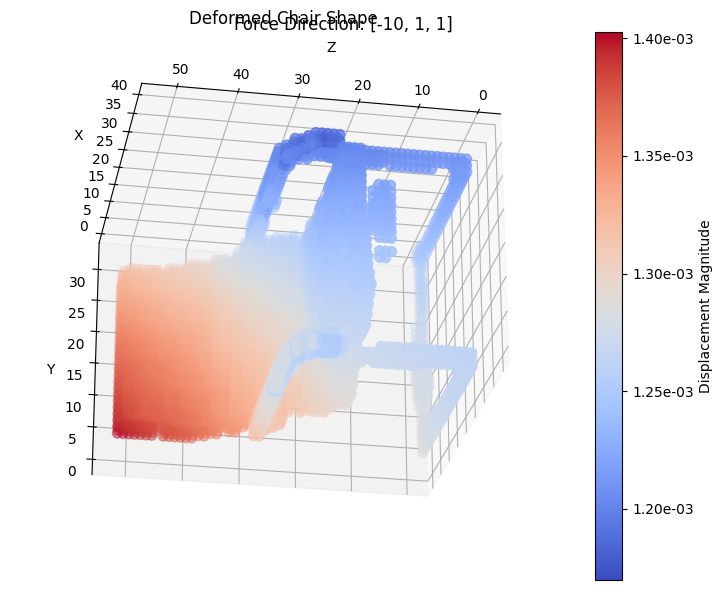

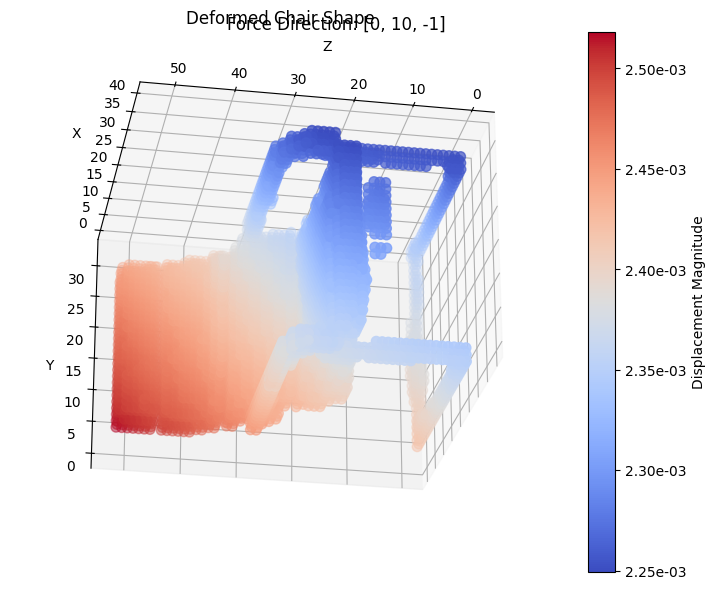

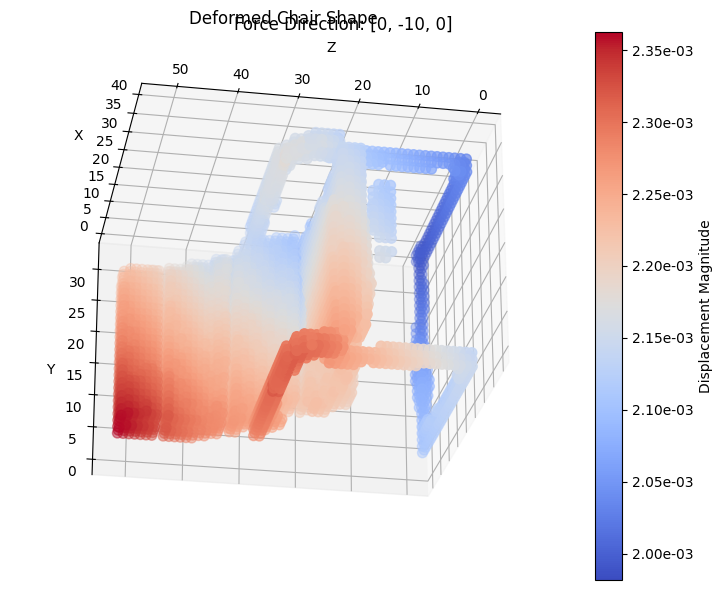

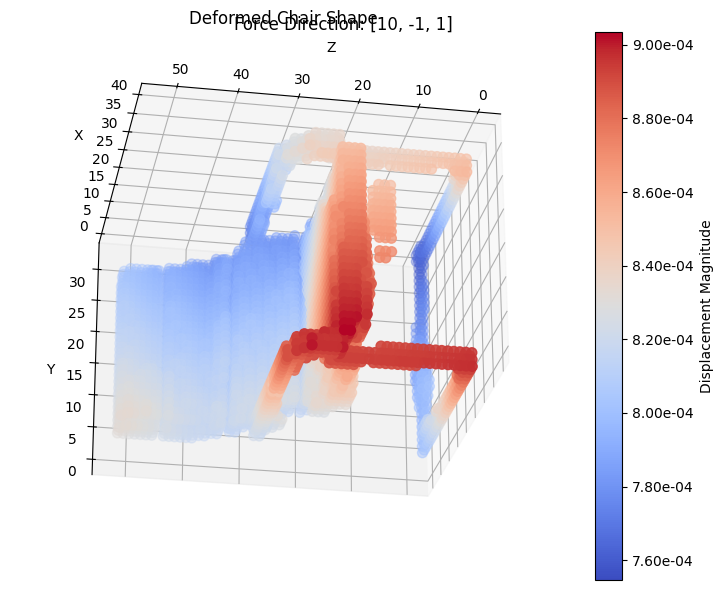

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat

def visualize_chair_deformation(voxel_file, model_file, force_direction):
    # Load the voxel data
    mat_data = loadmat(voxel_file)
    voxel_3d = mat_data['voxels3D']

    # Create a new instance of the model
    E = 1e9  # Young's modulus (Pa)
    nu = 0.3  # Poisson's ratio
    force_magnitude = 1.0  # 1000 N force
    chair_pinn = VoxelChairPINN(voxel_file, E, nu, force_magnitude)

    # Load the trained model weights
    chair_pinn.model.load_state_dict(torch.load(model_file))
    chair_pinn.model.eval()

    # Get the predicted displacements
    u, v, w = chair_pinn.get_displacement(torch.tensor(force_direction))

    # Create a 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scale factor for deformation (adjust as needed)
    scale = 10  # Increase this value to exaggerate the deformation
    
    x, y, z = np.meshgrid(np.arange(voxel_3d.shape[1]),
                          np.arange(voxel_3d.shape[0]),
                          np.arange(voxel_3d.shape[2]))
    
    # Apply deformation
    x_deformed = x + scale * u
    y_deformed = y + scale * v
    z_deformed = z + scale * w

    # Calculate displacement magnitude
    displacement_magnitude = np.sqrt(u**2 + v**2 + w**2)

    # Plot only the voxels that are part of the chair
    mask = voxel_3d.astype(bool)
    scatter = ax.scatter(x_deformed[mask], y_deformed[mask], z_deformed[mask],
                         c=displacement_magnitude[mask], cmap='coolwarm', s=50)
    
    # Customize the plot
    ax.set_xlabel('Z')
    ax.set_ylabel('X')
    ax.set_zlabel('Y')
    ax.set_title('Deformed Chair Shape')
    ax.view_init(elev=-25, azim=80)

    # Add colorbar to show displacement magnitude
    cbar = plt.colorbar(scatter, ax=ax, label='Displacement Magnitude')
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2e}"))

    # Add text to show force direction
    plt.figtext(0.5, 0.95, f'Force Direction: {force_direction}', ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

# Test the visualization
voxel_file = '/kaggle/input/datafile/discretized_voxel.mat'  # Replace with your .mat file name
model_file = 'trained_voxel_chair_model.pth'  # The saved model file

# Test with different force directions
force_directions = [
    [-10, 1, 1],  # Downward
    [0, 10, -1],   # Right
    [0, -10, 0],   # Forward
    [10, -1, 1],   # Diagonal
]

for direction in force_directions:
    visualize_chair_deformation(voxel_file, model_file, direction)

**2D example**

Epoch 0, Loss: 13158.857421875
Epoch 50, Loss: 22.806880950927734
Epoch 100, Loss: 4.411150932312012
Epoch 150, Loss: 3.1773362159729004
Epoch 200, Loss: 2.5413172245025635
Epoch 250, Loss: 1.981107234954834
Epoch 300, Loss: 1.5108211040496826
Epoch 350, Loss: 1.1319249868392944
Epoch 400, Loss: 0.8374000787734985
Epoch 450, Loss: 0.6158950924873352
Epoch 500, Loss: 0.45444953441619873
Epoch 550, Loss: 0.3402020335197449
Epoch 600, Loss: 0.2614942193031311
Epoch 650, Loss: 0.20845964550971985
Epoch 700, Loss: 0.17323319613933563
Epoch 750, Loss: 0.14989520609378815
Epoch 800, Loss: 0.13420012593269348
Epoch 850, Loss: 0.12327097356319427
Epoch 900, Loss: 0.11523620784282684
Epoch 950, Loss: 0.1089354008436203
Epoch 1000, Loss: 0.10366704314947128
Epoch 1050, Loss: 0.09903468936681747
Epoch 1100, Loss: 0.09480994939804077
Epoch 1150, Loss: 0.09086902439594269
Epoch 1200, Loss: 0.08714038133621216
Epoch 1250, Loss: 0.08358520269393921
Epoch 1300, Loss: 0.08018172532320023
Epoch 1350, Los

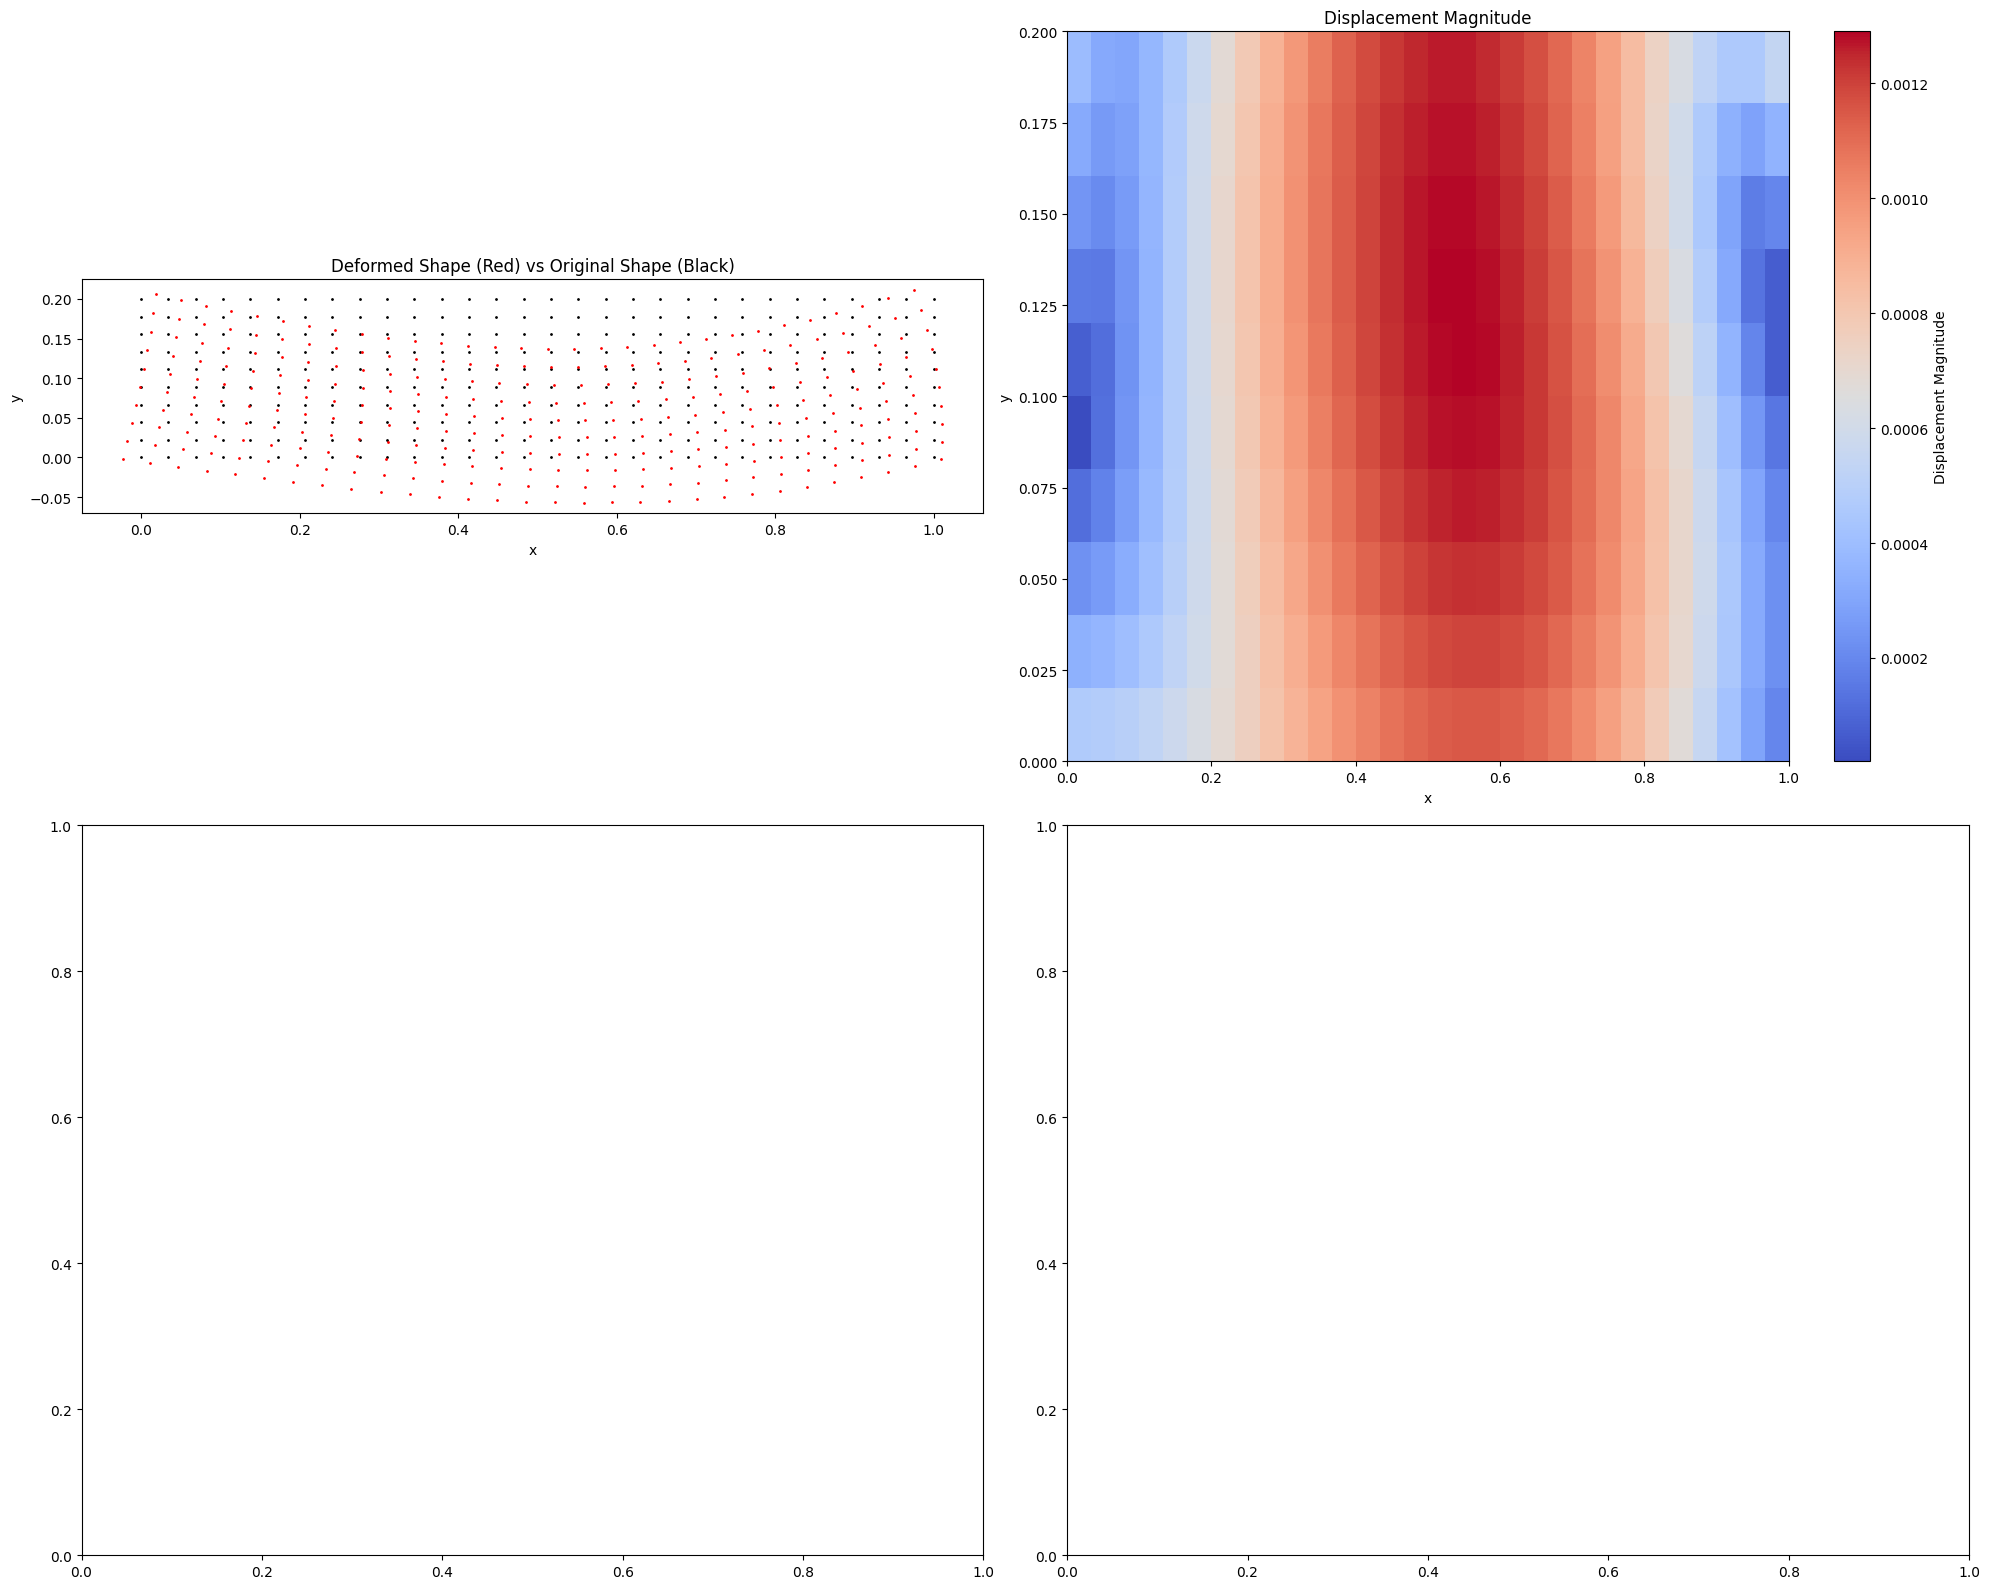

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.layer3(x)
        return x

class FlexibleDeepEnergyPINN:
    def __init__(self, domain_size, num_points, E, nu):
        self.domain_size = domain_size
        self.num_points = num_points
        self.E = E  # Young's modulus
        self.nu = nu  # Poisson's ratio
        
        self.x = torch.linspace(0, domain_size[0], num_points[0], requires_grad=True)
        self.y = torch.linspace(0, domain_size[1], num_points[1], requires_grad=True)
        self.X, self.Y = torch.meshgrid(self.x, self.y)
        self.xy = torch.stack([self.X.flatten(), self.Y.flatten()], dim=1)
        
        self.model = FFNN(input_dim=2, hidden_dim=50, output_dim=2)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
        # Initialize boundary conditions and force as None
        self.boundary_conditions = None
        self.force = None
        
    def set_boundary_conditions(self, boundary_conditions):
        """
        Set the boundary conditions for the problem.
        boundary_conditions: A dictionary with keys 'left', 'right', 'top', 'bottom'
        Each value is a tuple (u_condition, v_condition) where each condition is a function
        that takes x and y as inputs and returns the prescribed displacement or None if free.
        """
        self.boundary_conditions = boundary_conditions
        
    def set_force(self, force_function):
        """
        Set the external force for the problem.
        force_function: A function that takes x and y as inputs and returns a tuple (fx, fy)
        """
        self.force = force_function
        
    def strain_energy_density(self, u, v, x, y):
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        
        epsilon_xx = u_x
        epsilon_yy = v_y
        epsilon_xy = 0.5 * (u_y + v_x)
        
        sigma_xx = self.E / (1 - self.nu**2) * (epsilon_xx + self.nu * epsilon_yy)
        sigma_yy = self.E / (1 - self.nu**2) * (self.nu * epsilon_xx + epsilon_yy)
        sigma_xy = self.E / (2 * (1 + self.nu)) * epsilon_xy
        
        return 0.5 * (sigma_xx * epsilon_xx + sigma_yy * epsilon_yy + 2 * sigma_xy * epsilon_xy)
    
    def internal_energy(self, u, v):
        strain_energy = self.strain_energy_density(u, v, self.X, self.Y)
        E_in = torch.sum(strain_energy) * (self.domain_size[0] / self.num_points[0]) * (self.domain_size[1] / self.num_points[1])
        return E_in
    
    def external_work(self, u, v):
        if self.force is None:
            return 0
        
        fx, fy = self.force(self.X, self.Y)
        E_ex = torch.sum(fx * u + fy * v) * (self.domain_size[0] / self.num_points[0]) * (self.domain_size[1] / self.num_points[1])
        return E_ex
    
    def boundary_constraint(self, u, v):
        if self.boundary_conditions is None:
            return 0
        
        constraint = 0
        for edge, (u_cond, v_cond) in self.boundary_conditions.items():
            if edge == 'left':
                u_edge, v_edge = u[0, :], v[0, :]
                x_edge, y_edge = self.X[0, :], self.Y[0, :]
            elif edge == 'right':
                u_edge, v_edge = u[-1, :], v[-1, :]
                x_edge, y_edge = self.X[-1, :], self.Y[-1, :]
            elif edge == 'bottom':
                u_edge, v_edge = u[:, 0], v[:, 0]
                x_edge, y_edge = self.X[:, 0], self.Y[:, 0]
            elif edge == 'top':
                u_edge, v_edge = u[:, -1], v[:, -1]
                x_edge, y_edge = self.X[:, -1], self.Y[:, -1]
            
            if u_cond:
                u_prescribed = u_cond(x_edge, y_edge)
                constraint += torch.mean((u_edge - u_prescribed)**2)
            if v_cond:
                v_prescribed = v_cond(x_edge, y_edge)
                constraint += torch.mean((v_edge - v_prescribed)**2)
        
        return constraint
    
    def dem_pinn_loss(self):
        u, v = self.model(self.xy).T
        u = u.reshape(self.num_points)
        v = v.reshape(self.num_points)
        
        E_in = self.internal_energy(u, v)
        E_ex = self.external_work(u, v)
        boundary_constraint = self.boundary_constraint(u, v)
        
        return E_in - E_ex + 1e5 * boundary_constraint
    
    def train(self, num_epochs):
        for epoch in range(num_epochs):
            self.optimizer.zero_grad()
            loss = self.dem_pinn_loss()
            loss.backward()
            self.optimizer.step()
            
            if epoch % 50 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    def get_displacement(self):
        with torch.no_grad():
            u, v = self.model(self.xy).T
        return u.reshape(self.num_points).numpy(), v.reshape(self.num_points).numpy()

# Example usage
domain_size = (1.0, 0.2)  # Length = 1.0, Height = 0.2
num_points = (30, 10)  # 30 points along length, 10 points along height
E = 1e5  # Young's modulus
nu = 0.3  # Poisson's ratio

pinn = FlexibleDeepEnergyPINN(domain_size, num_points, E, nu)



# Define boundary conditions for fixed ends
def zero_displacement(x, y):
    return torch.zeros_like(x)

pinn.set_boundary_conditions({
    'left': (zero_displacement, zero_displacement),
    'right': (zero_displacement, zero_displacement),
    'top': (None, None),
    'bottom': (None, None)
})

# Define force (downward force at the center of the top surface)
def force_function(x, y):
    fx = torch.zeros_like(x)
    fy = torch.zeros_like(y)
    #center_index = num_points[0] // 2
    #fy[center_index, -1] = 0.5
    fy[:, -1] = 400  # Uniform load on top surface
    return fx, fy

pinn.set_force(force_function)

    

# Train the model
pinn.train(num_epochs=2000)

# Get displacement results
u, v = pinn.get_displacement()

# Visualization (same as before)
displacement_magnitude = np.sqrt(u**2 + v**2)

fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Deformed shape
scale = 50  # Scale factor for displacement visualization
X, Y = np.meshgrid(np.linspace(0, domain_size[0], num_points[0]), 
                   np.linspace(0, domain_size[1], num_points[1]))
axs[0, 0].plot(X, Y, 'k.', markersize=2)  # Original shape
axs[0, 0].plot(X + scale*u.T, Y + scale*v.T, 'r.', markersize=2)  # Deformed shape
axs[0, 0].set_title('Deformed Shape (Red) vs Original Shape (Black)')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
axs[0, 0].set_aspect('equal')

# Plot 2: Displacement magnitude (coolwarm colormap)
im = axs[0, 1].imshow(displacement_magnitude.T, extent=[0, domain_size[0], 0, domain_size[1]], 
                      origin='lower', cmap='coolwarm', aspect='auto')
axs[0, 1].set_title('Displacement Magnitude')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
fig.colorbar(im, ax=axs[0, 1], label='Displacement Magnitude')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



# Save the trained model
torch.save(pinn.model.state_dict(), "flexible_trained_2d_model.pth")
